# Importing libraries and loading train, val, and agg count features

In [0]:
from google.colab import drive
drive.mount('/gdrive')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import gc
import random
import dask.dataframe as dd
import sys
import pickle
sns.set()
import lightgbm as lgb

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
#loading double variables
infile = open('/gdrive/My Drive/kaggle/pickles/doubles_counts', 'rb')
double_counts = pickle.load(infile)
infile.close()

#loading train data
infile = open('/gdrive/My Drive/kaggle/pickles/train_comb', 'rb')
train = pickle.load(infile)
infile.close()

#loading validation data
infile = open('/gdrive/My Drive/kaggle/pickles/val_data', 'rb')
val_data = pickle.load(infile)
infile.close()

## Merging agg counts on train and validation datasets

In [0]:
#merging on train set
for counts in double_counts: 
  col_name = '_'.join(counts.columns.values[0:2])
  counts.columns.values[2] = col_name
  train=train.merge(counts, on=list(counts.columns.values[0:2]), how='left')

In [0]:
#merging on val set
for counts in double_counts: 
  col_name = '_'.join(counts.columns.values[0:2])
  counts.columns.values[2] = col_name
  val_data=val_data.merge(counts, on=list(counts.columns.values[0:2]), how='left')

val_data.head(5)

gc.collect()

365

In [0]:
display(train.head(5))
display(train.columns)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day,ip_app,ip_device,ip_os,ip_channel,app_device,app_os,app_channel,device_os,device_channel,os_channel
0,204158,35,1,13,21,2017-11-06 15:41:07,2017-11-07 08:17:19,1,15,6,1,472,67,1,90633,20696,62371,38270839,297384,63980
1,29692,9,1,22,215,2017-11-06 16:00:02,2017-11-07 10:05:22,1,16,6,538,2972,78,180,15264245,656447,1479377,7200250,1312488,53994
2,64516,35,1,13,21,2017-11-06 16:00:02,2017-11-06 23:40:50,1,16,6,19,15573,3739,47,90633,20696,62371,38270839,297384,63980
3,172429,35,1,46,274,2017-11-06 16:00:03,2017-11-07 00:55:29,1,16,6,2,1278,5,1,90633,130,28713,283146,37954,70
4,199085,35,1,13,274,2017-11-06 16:00:04,2017-11-06 23:04:54,1,16,6,4,1008,322,3,90633,20696,28713,38270839,37954,9047


Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'hour', 'day', 'ip_app', 'ip_device', 'ip_os',
       'ip_channel', 'app_device', 'app_os', 'app_channel', 'device_os',
       'device_channel', 'os_channel'],
      dtype='object')

In [0]:
#training model with popular parameters
target = 'is_attributed'
predictors = ['ip', 'app', 'device', 'os', 'channel', 'hour', 'day', 'ip_app', 
              'ip_device', 'ip_os', 'ip_channel', 'app_device', 'app_os', 
              'app_channel', 'device_os', 'device_channel', 'os_channel']
categorical = ['hour', 'day', 'app', 'device', 'os', 'channel']

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 255,  
    'max_depth': 8,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,  
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
   # 'nthread': 8,
    'verbose': 0,
    'scale_pos_weight':99 
    }
    
dtrain = lgb.Dataset(train[predictors].values, label=train[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val_data[predictors].values, label=val_data[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.956198	valid's auc: 0.950326
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.969648	valid's auc: 0.965692
[3]	train's auc: 0.971337	valid's auc: 0.967524
[4]	train's auc: 0.972405	valid's auc: 0.968905
[5]	train's auc: 0.972189	valid's auc: 0.968543
[6]	train's auc: 0.972896	valid's auc: 0.969339
[7]	train's auc: 0.973425	valid's auc: 0.969704
[8]	train's auc: 0.973633	valid's auc: 0.970039
[9]	train's auc: 0.973781	valid's auc: 0.970215
[10]	train's auc: 0.973885	valid's auc: 0.97036
[11]	train's auc: 0.974	valid's auc: 0.970529
[12]	train's auc: 0.974143	valid's auc: 0.970718
[13]	train's auc: 0.974302	valid's auc: 0.970864
[14]	train's auc: 0.974362	valid's auc: 0.970915
[15]	train's auc: 0.974421	valid's auc: 0.971056
[16]	train's auc: 0.97447	valid's auc: 0.971125
[17]	train's auc: 0.974607	valid's auc: 0.971263
[18]	train's auc: 0.974648	valid's auc: 0.971322
[19]	train's auc: 0.974738	valid's auc: 0.971387
[20]	train's auc: 0.9

252

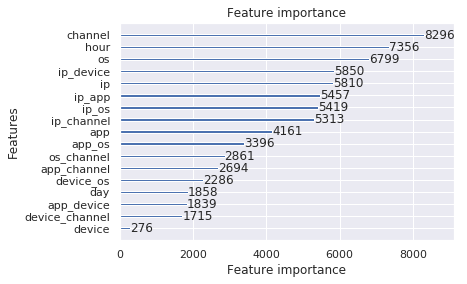

In [0]:
lgb.plot_importance(lgb_model, importance_type='split')
gc.collect()

4025

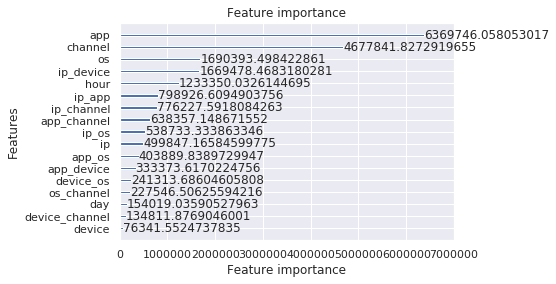

In [0]:
lgb.plot_importance(lgb_model, importance_type='gain')
gc.collect()

it looks like channel, os, and app are important by themselves. Device by itself is the least important and I'm going to remove all of the device interactions. Also removing day.  os_channel seems like it has a very low gain relative to how often it was used. Not sure why this is, but I'm going to remove this feature as well. 

In [0]:
gc.collect()

0

# Training round 2

Training model after removing low importance features

In [0]:
#training model with popular parameters
target = 'is_attributed'
predictors = ['ip', 'app', 'os', 'channel', 'hour', 'ip_app', 'ip_os', 'ip_channel', 
               'app_os', 'app_channel']
categorical = ['hour', 'app', 'os', 'channel']

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 255,  
    'max_depth': 8,  
    'min_child_samples': 100,  
    'max_bin': 100,  
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.7,  
    'min_child_weight': 0,  
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'reg_alpha': 0,  
    'reg_lambda': 0,  
   # 'nthread': 8,
    'verbose': 0,
    'scale_pos_weight':99 
    }
    
dtrain = lgb.Dataset(train[predictors].values, label=train[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val_data[predictors].values, label=val_data[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.96533	valid's auc: 0.961191
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.966836	valid's auc: 0.963032
[3]	train's auc: 0.968312	valid's auc: 0.964403
[4]	train's auc: 0.970566	valid's auc: 0.966521
[5]	train's auc: 0.971412	valid's auc: 0.967438
[6]	train's auc: 0.971595	valid's auc: 0.967731
[7]	train's auc: 0.971734	valid's auc: 0.967839
[8]	train's auc: 0.972205	valid's auc: 0.96835
[9]	train's auc: 0.972363	valid's auc: 0.968534
[10]	train's auc: 0.972545	valid's auc: 0.968752
[11]	train's auc: 0.972689	valid's auc: 0.96892
[12]	train's auc: 0.972818	valid's auc: 0.969072
[13]	train's auc: 0.972958	valid's auc: 0.969212
[14]	train's auc: 0.973014	valid's auc: 0.969292
[15]	train's auc: 0.973226	valid's auc: 0.969503
[16]	train's auc: 0.973371	valid's auc: 0.969632
[17]	train's auc: 0.973529	valid's auc: 0.969816
[18]	train's auc: 0.973596	valid's auc: 0.969919
[19]	train's auc: 0.973772	valid's auc: 0.970044
[20]	train's auc: 0

3463

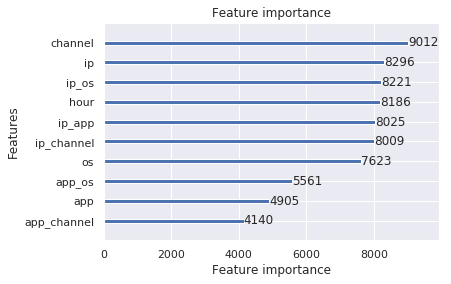

In [0]:
lgb.plot_importance(lgb_model, importance_type='split')
gc.collect()

2908

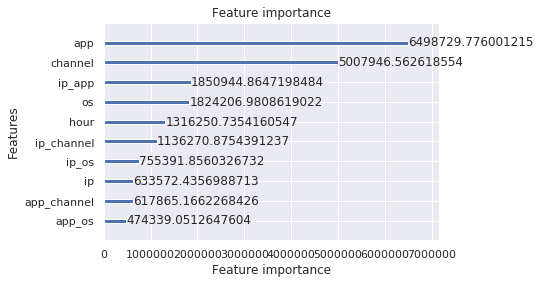

In [0]:
lgb.plot_importance(lgb_model, importance_type='gain')
gc.collect()

# Predicting on test set

I tried to predict using the whole test set but my session crashed. I'm splitting the test set into three sections and predicting one at a time, saving, deleting, and loading the next section. 

In [0]:
#connecting to kaggle and importing datasets
#from google.colab import files
#files.upload()
#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 /root/.kaggle/kaggle.json

#!kaggle competitions download -c talkingdata-adtracking-fraud-detection
#!unzip test.csv.zip
dypes = dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

#reading in training data sample
test=pd.read_csv('test.csv', dtype=dtypes)
test['hour'] = pd.to_datetime(test['click_time']).dt.hour.astype('uint8')
test['day'] = pd.to_datetime(test['click_time']).dt.day.astype('uint8')


In [0]:
test_1, test_2, test_3 = np.array_split(test, 3)

test_1.to_csv('/gdrive/My Drive/kaggle/test_1.csv')
test_2.to_csv('/gdrive/My Drive/kaggle/test_2.csv')
test_3.to_csv('/gdrive/My Drive/kaggle/test_3.csv')
del test, test_2, test_3
gc.collect()

192

In [0]:
#loading double variables
infile = open('/gdrive/My Drive/kaggle/pickles/doubles_counts_test', 'rb')
double_counts = pickle.load(infile)
infile.close()

#merging on test set
for counts in double_counts: 
  col_name = '_'.join(counts.columns.values[0:2])
  counts.columns.values[2] = col_name
  test_1=test_1.merge(counts, on=list(counts.columns.values[0:2]), how='left')

gc.collect()
test_1.isnull().sum()


Unnamed: 0        0
click_id          0
ip                0
app               0
device            0
os                0
channel           0
click_time        0
hour              0
day               0
ip_app            0
ip_device         0
ip_os             0
ip_channel        0
app_device        0
app_os            0
app_channel       0
device_os         0
device_channel    0
os_channel        0
dtype: int64

In [0]:
#predicting on test data
y_pred=lgb_model.predict(test_1[predictors], num_iteration=lgb_model.best_iteration)

test_1['is_attributed']=0
test_1.loc[y_pred>0.5, 'is_attributed']=1
test_1['is_attributed'].value_counts()

1    4304797
0    1958693
Name: is_attributed, dtype: int64

In [0]:
1958693/len(test_1)

0.3127159139712844

The model is waaay overclassifying not_attributed clicks. I think because the dataset that we're training on is too balanced. Going to try to train on a dataset that's closer to actual distribution

In [0]:
train['is_attributed'].value_counts()

0    921650
1    456846
Name: is_attributed, dtype: int64

# Train Round 3 

Making train and val datasets closer to actual distribution. The proportion is still larger (2% vs .02%) but I just want to see if this makes a difference

In [0]:
train_subset = train[train['is_attributed']==0]
train_subset = train_subset.append(train[train['is_attributed']==1].sample(n=round(len(train)*.02)))
display(train_subset.is_attributed.value_counts())

val_subset = val_data[val_data['is_attributed']==0]
val_subset = val_subset.append(val_data[val_data['is_attributed']==1].sample(n=round(len(val_data)*.02)))
display(val_subset.is_attributed.value_counts())

In [0]:
dtrain= lgb.Dataset(train_subset[predictors].values, label=train_subset[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val_subset[predictors].values, label=val_subset[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.968096	valid's auc: 0.963717
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.971412	valid's auc: 0.964071
[3]	train's auc: 0.97384	valid's auc: 0.964831
[4]	train's auc: 0.975565	valid's auc: 0.965899
[5]	train's auc: 0.976745	valid's auc: 0.966054
[6]	train's auc: 0.97759	valid's auc: 0.966163
[7]	train's auc: 0.978335	valid's auc: 0.966549
[8]	train's auc: 0.979133	valid's auc: 0.967295
[9]	train's auc: 0.979745	valid's auc: 0.967444
[10]	train's auc: 0.980264	valid's auc: 0.967965
[11]	train's auc: 0.980626	valid's auc: 0.968326
[12]	train's auc: 0.981035	valid's auc: 0.968724
[13]	train's auc: 0.981257	valid's auc: 0.969017
[14]	train's auc: 0.981575	valid's auc: 0.969144
[15]	train's auc: 0.981859	valid's auc: 0.969346
[16]	train's auc: 0.982113	valid's auc: 0.969537
[17]	train's auc: 0.982372	valid's auc: 0.96961
[18]	train's auc: 0.982711	valid's auc: 0.969811
[19]	train's auc: 0.982965	valid's auc: 0.969947
[20]	train's auc: 0

In [0]:
#trying to predict on test_1 again
y_pred=lgb_model.predict(test_1[predictors], num_iteration=lgb_model.best_iteration)

test_1['is_attributed']=0
test_1.loc[y_pred>0.5, 'is_attributed']=1
test_1['is_attributed'].value_counts()

0    4243355
1    2020135
Name: is_attributed, dtype: int64

In [0]:
2020135/len(test_1)

0.3225254610448807

Hmm unfortunately still no difference. Going to try to make it even closer to actual distribution... I don't think this will help but let's try

# Train round 4 

Making train and val sets even closer to actual distribution

In [0]:
train_subset = train[train['is_attributed']==0]
train_subset = train_subset.append(train[train['is_attributed']==1].sample(n=round(len(train)*.0025)))
display(train_subset.is_attributed.value_counts())

val_subset = val_data[val_data['is_attributed']==0]
val_subset = val_subset.append(val_data[val_data['is_attributed']==1].sample(n=round(len(val_data)*.0025)))
display(val_subset.is_attributed.value_counts())


0    921650
1      3446
Name: is_attributed, dtype: int64

0    55000
1      268
Name: is_attributed, dtype: int64

In [0]:
#training model with popular parameters
target = 'is_attributed'
predictors = ['ip', 'app', 'os', 'channel']
categorical = ['ip', 'app', 'os', 'channel']


dtrain= lgb.Dataset(train_subset[predictors].values, label=train_subset[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val_subset[predictors].values, label=val_subset[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.953873	valid's auc: 0.937567
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.959511	valid's auc: 0.939571
[3]	train's auc: 0.954983	valid's auc: 0.93347
[4]	train's auc: 0.966415	valid's auc: 0.942245
[5]	train's auc: 0.968943	valid's auc: 0.942363
[6]	train's auc: 0.970853	valid's auc: 0.942886
[7]	train's auc: 0.971635	valid's auc: 0.943535
[8]	train's auc: 0.972666	valid's auc: 0.943848
[9]	train's auc: 0.97408	valid's auc: 0.94421
[10]	train's auc: 0.975244	valid's auc: 0.944754
[11]	train's auc: 0.976045	valid's auc: 0.944865
[12]	train's auc: 0.976952	valid's auc: 0.945019
[13]	train's auc: 0.977496	valid's auc: 0.945323
[14]	train's auc: 0.978364	valid's auc: 0.944984
[15]	train's auc: 0.97885	valid's auc: 0.944851
[16]	train's auc: 0.979447	valid's auc: 0.944728
[17]	train's auc: 0.97997	valid's auc: 0.94465
[18]	train's auc: 0.980483	valid's auc: 0.945225
[19]	train's auc: 0.98083	valid's auc: 0.945492
[20]	train's auc: 0.981

Hmm still overclassifying is_attributed. Going to remove the value counts featuers and see if it's a problem with the new features

# Train round 5 

Removing the click count features to see if this helps

In [0]:
#training model with popular parameters
target = 'is_attributed'
predictors = ['ip', 'app', 'os', 'channel']
categorical = ['ip', 'app', 'os', 'channel']


dtrain= lgb.Dataset(train_subset[predictors].values, label=train_subset[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
dvalid = lgb.Dataset(val_subset[predictors].values, label=val_subset[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )

evals_results = {}

lgb_model = lgb.train(params, 
                 dtrain, 
                 valid_sets=[dtrain, dvalid], 
                 valid_names=['train','valid'], 
                 evals_result=evals_results, 
                 num_boost_round=350,
                 early_stopping_rounds=30,
                 verbose_eval=True, 
                 feval=None)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	train's auc: 0.947095	valid's auc: 0.946324
Training until validation scores don't improve for 30 rounds.
[2]	train's auc: 0.957797	valid's auc: 0.952823
[3]	train's auc: 0.961829	valid's auc: 0.953526
[4]	train's auc: 0.964471	valid's auc: 0.955439
[5]	train's auc: 0.965814	valid's auc: 0.955426
[6]	train's auc: 0.967277	valid's auc: 0.956027
[7]	train's auc: 0.968319	valid's auc: 0.95607
[8]	train's auc: 0.969412	valid's auc: 0.956953
[9]	train's auc: 0.970016	valid's auc: 0.95737
[10]	train's auc: 0.970757	valid's auc: 0.958077
[11]	train's auc: 0.971052	valid's auc: 0.957935
[12]	train's auc: 0.971681	valid's auc: 0.958408
[13]	train's auc: 0.971941	valid's auc: 0.958391
[14]	train's auc: 0.972463	valid's auc: 0.958565
[15]	train's auc: 0.972654	valid's auc: 0.958553
[16]	train's auc: 0.973035	valid's auc: 0.958884
[17]	train's auc: 0.973228	valid's auc: 0.958934
[18]	train's auc: 0.973538	valid's auc: 0.958991
[19]	train's auc: 0.97377	valid's auc: 0.959095
[20]	train's auc: 0

In [0]:
#trying to predict on test_1 again
y_pred=lgb_model.predict(test_1[predictors], num_iteration=lgb_model.best_iteration)

test_1['is_attributed']=0
test_1.loc[y_pred>0.5, 'is_attributed']=1
test_1['is_attributed'].value_counts()

0    5392031
1     871459
Name: is_attributed, dtype: int64

In [0]:
871459/len(test_1)

0.1391331350413268

Hmmm it's not as bad as before but still heavily overclassifying. When I trained a model on the sample provided by kaggle, with a random split and no feature engineering it classified 2% as attributed and had an AUC around 0.85... Disappointing but will keep trying!

# Thoughts and next steps

I wonder if I need to be more selective about what records are included in the training and test datasets so they have as much overlap as possible; however, this doesn't seem practical for a real life setting. If we were trying to predict whether a click was going to lead to a download or whether a click was fraudulent, how would we do this real time without prior knowledge of a test set feature distribution?  

It also seems like the balance of the outcome variable highly affected the prediction where a balanced dataset caused our model to predict downloads at a rate that was way too high. Need to think of a better way to balance the dataset for training. 


---

To do:

* More feature engineering (time between clicks, mean clicks, is_attributed rate)
* Other models (neural net, random forest...)
* Select different train and validation datasets
* Hyperparameter tuning

  
---

Some questions for our mentor:

How can we more mindfully select our training and validation datasets?   
How should we balance the outcome of interest in the train and validation datasets?  
With a problem like this,  what are some practical feature engineering ideas that don't cause data leakage from the test dataset?  
What is your process for feature engineering?  
What are your methods for analyzing datasets of this scale?  